In [0]:
import os
import json
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
import torch
import torchtext
from torchtext.data import Field, LabelField
from torchtext.data import TabularDataset
from torchtext.data import Iterator, BucketIterator
import spacy
import en_core_web_sm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from tqdm import tqdm, trange
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
import time

In [39]:
manual_seed = 77
torch.manual_seed(manual_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed(manual_seed)

cuda


In [0]:
data100k = pd.read_csv('/content/drive/My Drive/milestone3/subset_100k (2).csv')

In [41]:
data100k.head(2)

,Unnamed: 0,index,text,labels
0,0,0,These girlfriends deserves a special mention f...,0
1,1,1,LeSean McCoy going through warmups with first ...,0


##Drop unneccessary columns and retain only the text and label columns

- text: the text generated from gpt2 and handwritten text
- labels:
    -  0 : gpt2 generated
    - 1 : human generated

In [42]:
dataset = data100k.drop(['Unnamed: 0', 'index'], axis = 1)
dataset.head(3)

,text,labels
0,These girlfriends deserves a special mention f...,0
1,LeSean McCoy going through warmups with first ...,0
2,Tom Curran has been called up to England's Ash...,0


In [0]:
df_shuffled = dataset.sample(frac=1, random_state=123)

In [0]:
train, validate, test = np.split(dataset.sample(frac=1, random_state=123), [int(.6*len(dataset)), int(.8*len(dataset))])


In [46]:
print(len(train), len(validate), len(test))

60000 20000 20000


pandas.core.frame.DataFrame

In [0]:
new = {'text' : ["These girlfriends deserves a special mention for going that extra mile, hopefully doesn't set too many guys off on the path towards outrageous demands.\n\n1. She knows the severity of man-flu\n\n2. All fun and games is all good\n\n3. A voucher that says 'I love you'\n\n4. When arguments don't drag on forever.\n\n5. Providing everything he needs.\n\n6. Very understanding\n\n7. As awesome a gesture as this is, we are worried about this man's cooking skills.\n\n8. Nice cake\n\n8. Fair bargaining\n\n9. Excellent gift choice\n\n10. Very thoughtful"",
                 "Pro Tour Amonkhet is now down to just eight players. Take a look at what they brought for this weekend's Standard rounds, and what they will be battling with on Sunday for the title of Pro Tour Champion.",
                 "Scientists can now visualize and experiment with structures and the dynamics of complex molecular makeup (at atomic-level precision), with real-time multi-user collaboration via the cloud\n\nJuly 6, 2018",
                 "Summary Focus of this page: This page discusses our current view of the evidence for a wide range of programs and interventions that aim to improve education in developing countries. These include demand-side interventions that lower the cost of schooling or increase its (perceived) returns, provision of school inputs, pedagogy interventions, and governance reforms. We focus mainly on interventions aimed at improving primary and secondary education but consider vocational training interventions briefly. We have not yet completed a report on early childhood (pre-school) interventions. On this page, we focus on evidence from experimental study designs.",
                 "If you look on a board game shelf, how many games will you see with actions based on collaboration, stewardship, generosity, and gratitude? Most likely, you'll find mechanics like attacking, stealing, and backstabbing. Indigenous communities looking to facilitate intergenerational gameplay are thus hard-pressed to find options that reinforce their teachings. In response, communities are developing their own games for passing on teachings in many forms. As espoused by game designer Brenda Romero, the mechanic is the message. And the messages in the board game The Gift of Food—inspired by collaborative game development with Indigenous communities working with the Northwest Indian College—produce culturally responsive gameplay, meaning gameplay that is drawn from and that uplifts the cultures involved.\n\nThe Gift of Food is an ideal example of how culturally responsive board games can function as important pathways for passing on Indigenous ways of knowing"],
        'labels' : [0,0,0,0,0]}

In [0]:
new_data = pd.DataFrame(new)
new_texts, new_labels = zip(*new_data.values)

In [0]:
train_texts, train_labels = zip(*train.values)

In [0]:
valid_texts, valid_labels = zip(*validate.values)
test_texts, test_labels = zip(*test.values)

In [0]:
n_jobs=None
verbose=False


vect = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)
train_features = vect.fit_transform(train_texts)
valid_features = vect.transform(valid_texts)
test_features = vect.transform(test_texts)

In [50]:
model = LogisticRegression(solver='liblinear')
params = {'C': [0.0001, 100]} #changed from original code
search = GridSearchCV(model, params, cv=5, n_jobs=n_jobs, verbose=verbose)
search.fit(sparse.vstack([train_features, valid_features]), train_labels+valid_labels)
print(search.best_params_)
model = model.set_params(**search.best_params_)

{'C': 100}


In [57]:
# n_jobs=None
# verbose=False


# vect = TfidfVectorizer(ngram_range=(1, 2), min_df=5, max_features=2**21)
# train_features = vect.fit_transform(train_texts)
# valid_features = vect.transform(valid_texts)
# test_features = vect.transform(test_texts)

# print('done vectorizing features')

# model = LogisticRegression(solver='liblinear')
# params = {'C': [0.0001, 100]} #changed from original code
# search = GridSearchCV(model, params, cv=5, n_jobs=n_jobs, verbose=verbose)
# search.fit(sparse.vstack([train_features, valid_features]), train_labels+valid_labels)
# print(search.best_params_)
# model = model.set_params(**search.best_params_)
model.fit(train_features, train_labels)
print('model has been fit')
valid_accuracy = model.score(valid_features, valid_labels)*100.
test_accuracy = model.score(test_features, test_labels)*100.
data = {
    'valid_accuracy':valid_accuracy,
    'test_accuracy':test_accuracy
}
print(data)

model has been fit
{'valid_accuracy': 88.235, 'test_accuracy': 88.21}


In [0]:
test_predictions = model.predict(test_features)

In [0]:
print(type(test_labels), type(test_predictions))

<class 'tuple'> <class 'numpy.ndarray'>


In [0]:
true_test = list(test_labels)
predictions = list(test_predictions)

In [0]:
cm = confusion_matrix(true_test, predictions)

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[8843 1163]
 [1195 8799]]


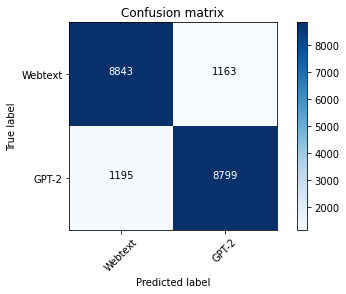

In [62]:
plot_confusion_matrix(cm, ("Webtext", "GPT-2"))


In [0]:
new_features = vect.transform(new_texts)

In [67]:
model.predict(new_features)

array([0, 0, 0, 0, 0])